In [812]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [813]:
data = pd.read_csv('California_Houses.csv')

In [814]:
# splitting the data
# random_state ensures that every time the same random sample is taken
training_data = data.sample(frac=0.7,random_state = 42)
rest_of_data = data.drop(training_data.index)
validation_data = rest_of_data.sample(frac=0.5,random_state = 42)
testing_data = rest_of_data.drop(validation_data.index)

In [815]:
# getting our targets for training
matrix_t = training_data["Median_House_Value"].values
matrix_t = matrix_t.reshape(-1, 1) # as a column vector
# getting our targets for tuning the lambda
target_validate = validation_data["Median_House_Value"].values
target_validate = target_validate.reshape(-1,1)
# getting our targets for testing
target_test = testing_data["Median_House_Value"].values
target_test = target_test.reshape(-1,1)


In [816]:
# adding the column of ones to our matrix
num_of_samples = training_data["Median_House_Value"].count()
ones_col_train = np.ones((num_of_samples,1))
ones_col_val = np.ones((validation_data["Median_House_Value"].count(),1))
ones_col_test = np.ones((testing_data["Median_House_Value"].count(),1))


In [817]:
# dropping the target column
input_data = training_data.drop(columns=["Median_House_Value"], inplace=False)
val_data = validation_data.drop(columns=["Median_House_Value"], inplace=False)
test_data = testing_data.drop(columns=["Median_House_Value"], inplace=False)

In [818]:
# building our maitrces
matrix_x = np.hstack([ones_col_train, input_data])
matrix_xt = matrix_x.T
print(matrix_x.shape)
matrix_x_val = np.hstack([ones_col_val, val_data])
matrix_x_test = np.hstack([ones_col_test, test_data])


(14448, 14)


In [819]:
lambda_values = [0.001, 0.01, 0.1, 1, 10, 100]  # regularization parameter
I = np.eye(matrix_x.shape[1])  # identity matrix
I[0, 0] = 0 # removing the bias from the regularization
 # ridge regression equation
mse_values = []
for l in lambda_values:
    inverse_m = np.linalg.pinv(np.dot(matrix_xt, matrix_x) + l * I)
    weights = np.dot(np.dot(inverse_m,  matrix_xt ), matrix_t)
    y_predicted = np.dot(matrix_x_val, weights)
    val = np.sum((y_predicted - target_validate)**2) / y_predicted.shape[0]
    mse_values.append(val)
best_lambda = lambda_values[np.argmin(mse_values)]
# mse and mae for best lambda using test data
inverse_m = np.linalg.pinv(np.dot(matrix_xt, matrix_x) + best_lambda * I)
weights = np.dot(np.dot(inverse_m,  matrix_xt ), matrix_t)
y_predicted_man = np.dot(matrix_x_test, weights)
mse = np.sum((y_predicted_man - target_test)**2) / y_predicted_man.shape[0]
mae = np.mean(np.abs(y_predicted_man - target_test))
print(f"the mean absolute error for manual ridge regression = {mae}")
print(f"the mean squared error for manual ridge regression = {mse}")



the mean absolute error for manual ridge regression = 50671.15776855078
the mean squared error for manual ridge regression = 4923790635.9005


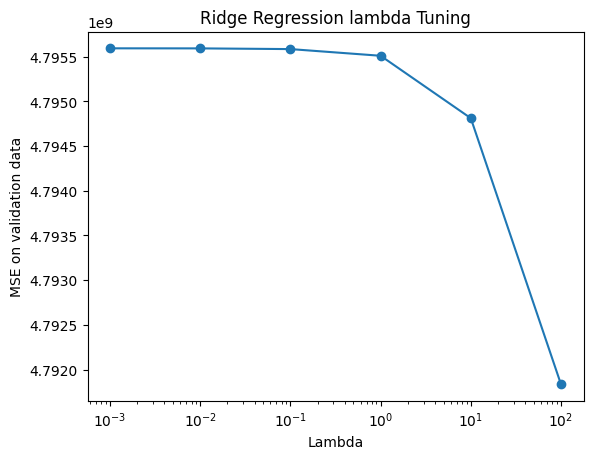

In [820]:
# plot for different lambdas aganist the MSE
plt.plot(lambda_values, mse_values, marker='o')
plt.xscale('log')
plt.xlabel("Lambda")
plt.ylabel("MSE on validation data")
plt.title("Ridge Regression lambda Tuning")
plt.show()

In [821]:
# implementing ridge using sklearn
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import RidgeCV



In [822]:
ridge_model = Ridge(alpha=best_lambda, fit_intercept=False)
ridge_model.fit(matrix_x, matrix_t)
print(ridge_model.coef_)

[-1.24770298e+03  3.86223092e+04  8.58471689e+02 -4.48947200e+00
  8.55112626e+01 -4.54234231e+01  7.36025869e+01 -4.87998073e+04
 -1.41193411e+04 -3.29323667e-01 -1.63001136e-01  3.56843203e-01
  1.31769784e-01 -1.35230510e-01]


In [823]:
y_pred_sk = ridge_model.predict(matrix_x_test)
mse = mean_squared_error(target_test, y_pred_sk)
mae = mean_absolute_error(target_test, y_pred_sk)
r2 = r2_score(target_validate, y_pred_sk)
print(f"the mean absolute error for sklearn ridge regression = {mae}")
print(f"the mean squared error for sklearn ridge regression = {mse}")


the mean absolute error for sklearn ridge regression = 50671.008520776835
the mean squared error for sklearn ridge regression = 4923771251.706618


In [824]:
## Normalizing our data (excluding bias column)
x_mean = np.mean(matrix_x[:, 1:], axis=0)
x_std = np.std(matrix_x[:, 1:], axis=0)

x_std[x_std == 0] = 1


matrix_x_norm = matrix_x.copy()
matrix_x_norm[:, 1:] = (matrix_x[:, 1:] - x_mean) / x_std
matrix_xt_norm = matrix_x_norm.T

t_mean = np.mean(matrix_t)
t_std = np.std(matrix_t)
if t_std == 0:
    t_std = 1

matrix_t_norm = (matrix_t - t_mean) / t_std


In [825]:
# gradiant descent
def gradiant_descent(alpha):

    w = np.zeros((14,1)) # the intial guess for the gd
    tolerance = 1e-5
    max_iterations = 10000
    for _ in range(max_iterations):
        mult = np.dot(matrix_xt_norm,np.dot(matrix_x_norm,w)-matrix_t_norm)+(best_lambda*w)
        derivative = np.divide(mult,num_of_samples)
        w = w - (alpha*derivative)
        if np.linalg.norm(derivative) < tolerance:
            break
    w_actual = np.zeros_like(w)
    b_actual = t_mean - np.sum((x_mean / x_std) * (t_std * w[1:,0])) + t_std * w[0,0]
    w_actual[0,0] = b_actual
    w_actual[1:] = (t_std / x_std.reshape(-1, 1)) * w[1: ] 
    return w_actual


In [826]:
# tuning for alpha while we already chose the best lambda
alphas = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]  # very small alpha values for normalized data
mse_values = []
for alpha in alphas:
    w_gd = gradiant_descent(alpha)
    y_predicted = np.dot(matrix_x_val, w_gd)
    val = np.sum((y_predicted - target_validate)**2) / y_predicted.shape[0]
    mse_values.append(val)
best_alpha = alphas[np.argmin(mse_values)]

# getting the mae and mse for the best alpha using the test data
w_gd = gradiant_descent(best_alpha)
y_predicted_gd = np.dot(matrix_x_test, w_gd)
mse = np.sum((y_predicted_gd - target_test)**2) / y_predicted_gd.shape[0]
mae = np.mean(np.abs(y_predicted_gd - target_test))
print(f"the mean absolute error for gradiant descent  = {mae}")
print(f"the mean squared error for gradiant descent= {mse}")


the mean absolute error for gradiant descent  = 50903.102681634366
the mean squared error for gradiant descent= 4929180413.654803


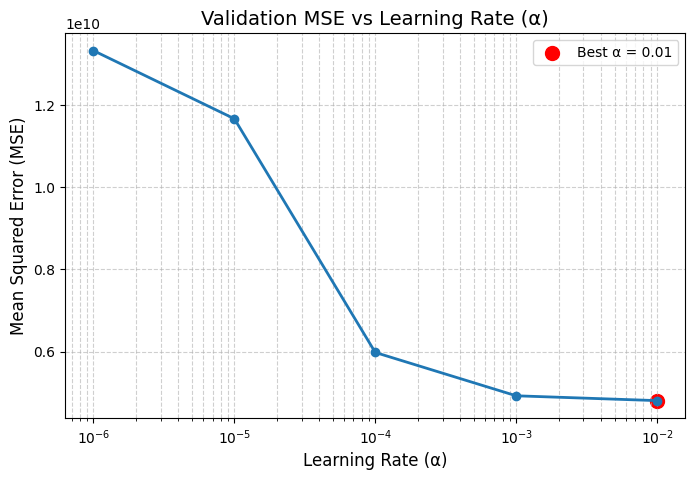

In [827]:
# Create the plot
plt.figure(figsize=(8, 5))
plt.plot(alphas, mse_values, marker='o', linestyle='-', linewidth=2, markersize=6)

# Log-scale for alpha (since learning rates vary exponentially)
plt.xscale('log')

# Labels and title
plt.title("Validation MSE vs Learning Rate (α)", fontsize=14)
plt.xlabel("Learning Rate (α)", fontsize=12)
plt.ylabel("Mean Squared Error (MSE)", fontsize=12)

# Optional: show grid and best point
plt.grid(True, which="both", ls="--", alpha=0.6)

# Highlight the best alpha
best_idx = np.argmin(mse_values)
plt.scatter(alphas[best_idx], mse_values[best_idx], color='red', s=100, label=f"Best α = {alphas[best_idx]}")
plt.legend()

plt.show()

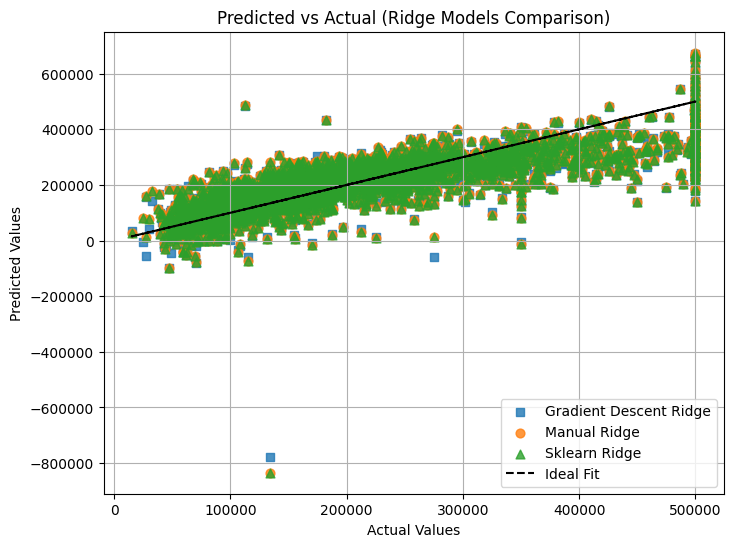

In [828]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(target_test, y_predicted_gd, label='Gradient Descent Ridge', alpha=0.8, s=40, marker='s')
plt.scatter(target_test, y_predicted_man, label='Manual Ridge', alpha=0.8,  s=40, marker='o')
plt.scatter(target_test, y_pred_sk, label='Sklearn Ridge', alpha=0.8, s=40, marker='^')
plt.plot(target_test, target_test, color='black', linestyle='--', label='Ideal Fit')

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual (Ridge Models Comparison)")
plt.legend()
plt.grid(True)
plt.show()


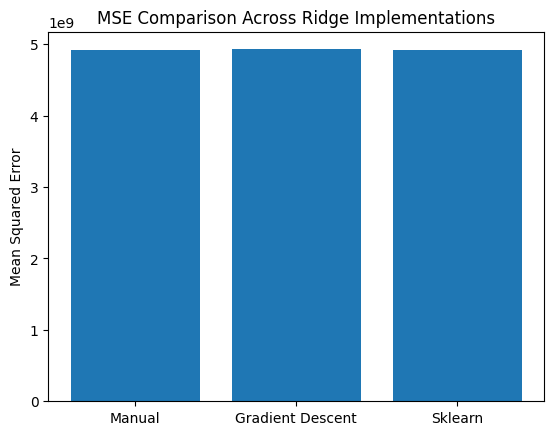

In [829]:
mse_manual = mean_squared_error(target_test, y_predicted_man)
mse_gd = mean_squared_error(target_test, y_predicted_gd)
mse_sklearn = mean_squared_error(target_test, y_pred_sk)

plt.bar(['Manual', 'Gradient Descent', 'Sklearn'], [mse_manual, mse_gd, mse_sklearn])
plt.ylabel('Mean Squared Error')
plt.title('MSE Comparison Across Ridge Implementations')
plt.show()